# Final Project: WSJ Modeling of Predicting the Direction of the S&P500

__Background:__ This is a capstone project for FlatIron School. Each student was given the opportunity to pick a project that interested them most. I find the WSJ and finacial markets very interesting so I decided to combine those two passions of mine. The following notebook goes through the OSEMN framework to do a bit of EDA and NLP modeling on the WSJ homepage. I hope you enjoy!

__Approach:__  
The standard OSEMN framework was used for the entirety of the project. Below are the details of the different packages, websites, and tools used throughout the notebook.


__OSEMN__
1. Obtain: The data needed to be scraped from the WSJ homepage. To do this the waybackmachine was used; a historical archive of essentially almost any website with multiple snapshots of a website each day. Using Selenium, a web browser automation package, I easily scrapped the homepage for the headers and sub headers from Jan 1,2019 until present day.  
    In addition to the wsj headlines, the stock market data was needed untilamtely for the labels or the Y variable. For this, I used yahoo finances downloadable CSV file.  

  
2. Scrub: The data needed the traditional Natural Language Processing cleaning. This consisted of eliminating stop words and any other english lanugage words or symbols that appeared most frequently throughout the WSJ. Along with this, all text data was lower cased to compare apples to apples for the computers sake. All of the text data was put into a dataframe along with the corresponding label of a positive or negative day represented as 1 or -1 respectively.


3. Explore: A little bit of exploratory data analysis was conducted before the modeling to gain insight into the extracted data. The positive and negative days term frequency distributions were compared to eachother. Along with different NLP methods were used such as bigrams vs. stemming vs. lemmatization. 


4. Model: For each of the different NLP strategies, I decided to run a very basic logistic regression model. After, I decided to run with a neural network to see if I could get my accuracy up any further. 


5. Interpret: I will leave the interpretation to the end of the notebook. If you wish to see just scroll all the way to the conclusion at the bottom of the notebook. Thank you! 

In [1]:
from selenium import webdriver #Selenium web driver
from selenium.webdriver.common.keys import Keys #Selenium wkeys
from bs4 import BeautifulSoup #BeatifulSoup for webscraping
import re #Regular Expression package
import pandas as pd #Pandas dataframes and etc.
import os #Used for shell commands
import numpy as np #NUmpy package
import matplotlib.pyplot as plt #Matplotlib graphing package
%matplotlib inline
# from sklearn.manifold import TSNE
import nltk #NLTK NLP Package
from nltk.tokenize import word_tokenize #NLTK NLP Package
np.random.seed(0)
from nltk.corpus import gutenberg, stopwords #NLTK NLP Package
from nltk.collocations import * #NLTK NLP Package
from nltk import FreqDist #NLTK NLP Package
from nltk import word_tokenize #NLTK NLP Package
from nltk.stem.porter import * #NLTK Stemming
from nltk.stem import WordNetLemmatizer #NLTK Lemmatization
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator #WordCloud Package
from PIL import Image ##WordCloud Package assistance for WSJ image
from sklearn.model_selection import train_test_split #Sklearn modeling etc. 
from sklearn.feature_extraction.text import CountVectorizer #Sklearn modeling etc.
from sklearn.linear_model import LogisticRegression #Sklearn modeling etc.
import seaborn as sns #Seaborn
from keras.preprocessing.text import Tokenizer #Keras Tokenizer
from keras.preprocessing.sequence import pad_sequences #Keras padding
from keras.models import Sequential #Keras Sequential Decl.
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D #Neural Networks
from keras.utils.np_utils import to_categorical #Encoding labeling
from keras.callbacks import EarlyStopping #Keras early stopback
from keras.layers import Dropout #Dropout
import re


Using TensorFlow backend.


## Retrieve Data

First we need to retrieve the financial market data from yahoo finance. Historical data in the form of a csv is available through direct download at the following link, https://finance.yahoo.com/quote/%5EGSPC/history?p=%5EGSPC.

In [2]:
sp_500=pd.read_csv('S&P 500 Data.csv') #Obtaining the market data

In [3]:
sp_500.head()

Date         Open         High          Low        Close  \
0  10/22/2018  2773.939941  2778.939941  2749.219971  2755.879883   
1  10/23/2018  2721.030029  2753.590088  2691.429932  2740.689941   
2  10/24/2018  2737.870117  2742.590088  2651.889893  2656.100098   
3  10/25/2018  2674.879883  2722.699951  2667.840088  2705.570068   
4  10/26/2018  2667.860107  2692.379883  2628.159912  2658.689941   

     Adj Close      Volume  
0  2755.879883  3307140000  
1  2740.689941  4348580000  
2  2656.100098  4709310000  
3  2705.570068  4634770000  
4  2658.689941  4803150000

In [4]:
sp_500['Change']=sp_500['Close']-sp_500['Open'] #Creating a new column for the change in S&P500

In [5]:
sp_500_final= sp_500[['Date','Change']] #creating new dataframe with just the date and change in S&P500

In [6]:
sp_500_final.head()

Date     Change
0  10/22/2018 -18.060058
1  10/23/2018  19.659912
2  10/24/2018 -81.770019
3  10/25/2018  30.690185
4  10/26/2018  -9.170166

In [7]:
Encode=pd.DataFrame(sp_500_final['Change'].where(sp_500_final['Change']<0, other=1)) #Coding the positive vs. negative days

In [8]:
encoded_data=pd.DataFrame(Encode.where(Encode>0,-1))

In [9]:
encoded_data.columns=['Coded']

In [10]:
sp_500=pd.concat([sp_500_final,encoded_data], axis=1)

In [11]:
sp_500.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 3 columns):
Date      251 non-null object
Change    251 non-null float64
Coded     251 non-null float64
dtypes: float64(2), object(1)
memory usage: 6.0+ KB


In [12]:
sp_500.Date = pd.to_datetime(sp_500.Date) #changing the date column to a datetime object for easy merging later on

In [13]:
sp_500.head()

Date     Change  Coded
0 2018-10-22 -18.060058   -1.0
1 2018-10-23  19.659912    1.0
2 2018-10-24 -81.770019   -1.0
3 2018-10-25  30.690185    1.0
4 2018-10-26  -9.170166   -1.0

Now to use Beautful Soup to webscrape the wayback machine. The wayback machine is a open source website that stores historical webcrawls of many websites. I am going to use the wayback machine to webscrape the WSJ front page. From there I will scrape just the headlines and the sub headings to perform Natural Language Processing. 

In [14]:
url= 'https://web.archive.org/web/*/wsj.com' #URL homepage for WSJ of all different days
driver = webdriver.Chrome(executable_path=r'C:\Users\GBLS\Downloads\chromedriver_win32\chromedriver') #driver
driver.get('https://web.archive.org/web/*/wsj.com') #Automation of going to website

In [15]:
my_html = driver.page_source #Getting the HTML
soup = BeautifulSoup(my_html, 'html.parser')

In [16]:
print(soup.prettify())

<html lang="en">
 <head>
  <title>
   Wayback Machine
  </title>
  <script src="//archive.org/includes/jquery-1.10.2.min.js?v1.10.2" type="text/javascript">
  </script>
  <script src="//archive.org/includes/analytics.js?v=91331656" type="text/javascript">
  </script>
  <script src="//archive.org/includes/build/npm/jquery-ui.min.js?v1.12.1" type="text/javascript">
  </script>
  <script src="//archive.org/includes/bootstrap.min.js?v3.0.0" type="text/javascript">
  </script>
  <script src="//archive.org/components/npm/clipboard/dist/clipboard.js?v=91331656" type="text/javascript">
  </script>
  <script src="//archive.org/includes/build/npm/react/umd/react.production.min.js?v16.7.0" type="text/javascript">
  </script>
  <script src="//archive.org/includes/build/npm/react-dom/umd/react-dom.production.min.js?v16.7.0" type="text/javascript">
  </script>
  <script src="//archive.org/includes/build/js/archive.min.js?v=91331656" type="text/javascript">
  </script>
  <script src="//archive.org/in

The code above is all of the HTML of the webpage. The links to the different dates is what was needed. To do this, beutiful soups find all method was used to search for the links.

In [17]:
links=soup.find_all('a')

In [18]:
links #looking at all links

[<a data-action="ia-banner-close" href="#"></a>,
 <a class="navia-link home" href="/" target="_top" title="Home">
 <span class="iconochive-logo"></span>
 <span>Home</span>
 </a>,
 <a class="navia-link web" data-top-kind="web" href="https://archive.org/web/" target="_top" title="Web"><span aria-hidden="true" class="iconochive-web"></span><span>web</span></a>,
 <a class="navia-link texts" data-top-kind="texts" href="https://archive.org/details/texts" target="_top" title="Texts"><span aria-hidden="true" class="iconochive-texts"></span><span>books</span></a>,
 <a class="navia-link movies" data-top-kind="movies" href="https://archive.org/details/movies" target="_top" title="Video"><span aria-hidden="true" class="iconochive-movies"></span><span>video</span></a>,
 <a class="navia-link audio" data-top-kind="audio" href="https://archive.org/details/audio" target="_top" title="Audio"><span aria-hidden="true" class="iconochive-audio"></span><span>audio</span></a>,
 <a class="navia-link software" 

Now that all the links were printed, the only links needed are the direct access links to each WSJ landing page for each specific day. The following for loop does exactly that; creating a list of only links that will take us to the landing page of each day. 

In [19]:
links_wsj= []
for x in links:
    if 'wsj' in x['href']:
        links_wsj.append(x['href'])

In [20]:
links_wsj

['/web/collections/*/wsj.com',
 '/web/changes/wsj.com',
 '/details/wsj.com',
 '/web/sitemap/wsj.com',
 '/web/19961203131021/wsj.com',
 '/web/20191114154136/wsj.com',
 '/web/20190101/wsj.com',
 '/web/20190102/wsj.com',
 '/web/20190103/wsj.com',
 '/web/20190104/wsj.com',
 '/web/20190105/wsj.com',
 '/web/20190106/wsj.com',
 '/web/20190107/wsj.com',
 '/web/20190108/wsj.com',
 '/web/20190109/wsj.com',
 '/web/20190110/wsj.com',
 '/web/20190111/wsj.com',
 '/web/20190112/wsj.com',
 '/web/20190113/wsj.com',
 '/web/20190114/wsj.com',
 '/web/20190115/wsj.com',
 '/web/20190116/wsj.com',
 '/web/20190117/wsj.com',
 '/web/20190118/wsj.com',
 '/web/20190119/wsj.com',
 '/web/20190120/wsj.com',
 '/web/20190121/wsj.com',
 '/web/20190122/wsj.com',
 '/web/20190123/wsj.com',
 '/web/20190124/wsj.com',
 '/web/20190125/wsj.com',
 '/web/20190126/wsj.com',
 '/web/20190127/wsj.com',
 '/web/20190128/wsj.com',
 '/web/20190129/wsj.com',
 '/web/20190130/wsj.com',
 '/web/20190131/wsj.com',
 '/web/20190201/wsj.com',
 '

The links needed to be made whole again so it easily can be fed into selenium. Thus, I decided to create another for loop to easily add on the neccesary text to create a valid link. 

In [21]:
full_link= []
for x in links_wsj:
    full_link.append('https://web.archive.org/'+ x)

In [22]:
full_link

['https://web.archive.org//web/collections/*/wsj.com',
 'https://web.archive.org//web/changes/wsj.com',
 'https://web.archive.org//details/wsj.com',
 'https://web.archive.org//web/sitemap/wsj.com',
 'https://web.archive.org//web/19961203131021/wsj.com',
 'https://web.archive.org//web/20191114154136/wsj.com',
 'https://web.archive.org//web/20190101/wsj.com',
 'https://web.archive.org//web/20190102/wsj.com',
 'https://web.archive.org//web/20190103/wsj.com',
 'https://web.archive.org//web/20190104/wsj.com',
 'https://web.archive.org//web/20190105/wsj.com',
 'https://web.archive.org//web/20190106/wsj.com',
 'https://web.archive.org//web/20190107/wsj.com',
 'https://web.archive.org//web/20190108/wsj.com',
 'https://web.archive.org//web/20190109/wsj.com',
 'https://web.archive.org//web/20190110/wsj.com',
 'https://web.archive.org//web/20190111/wsj.com',
 'https://web.archive.org//web/20190112/wsj.com',
 'https://web.archive.org//web/20190113/wsj.com',
 'https://web.archive.org//web/20190114/

In [23]:
jan=full_link[6:37] #Splitting up the links into each month to make for easy webscraping by month
feb=full_link[37:65]
mar=full_link[65:96]
apr=full_link[96:126]
may=full_link[126:157]
jun=full_link[157:187]
jul=full_link[187:218]
aug=full_link[218:249]
sept=full_link[249:279]
octb=full_link[279:310]

The following code was used to obtain all of the text data for each month from the weblinks I created above. It is divided by month and the following for loop is used to obtain just the headers of each page along with the subheading text. From here I added the date with the text and code (negative or positve day) into a dataframe. After the for loop, I check to ensure there are no NaN. 

Sometimes there are NaN due to it being the weekend and markets being closed. For these instances I used a method ffill() which is a fill foward method for dataframes. Once I checked for a complete clean dataframe, I saved each one into a csv file. 

In [29]:
date=[] #List created for dates
headline_blurb_data= [] #Headline and subheading list
for link in jan: 
    driver.get(str(link)) #Selenium getting the links from the provided month 
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}): #Obtaining the headings from each link's html
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the sub-headings
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data}) #Creating a dataframe 
df_wsj.Date= pd.to_datetime(df_wsj.Date) #Changing the date to a date time object
df_jan=df_wsj.merge(sp_500,how='left') #Merging into one dataframe

In [31]:
df_jan=df_jan.fillna(1)

In [32]:
df_jan.isna().sum()

Date      0
Text      0
Change    0
Coded     0
dtype: int64

In [33]:
df_jan.to_csv('January')

In [34]:
date=[] #List created for dates
headline_blurb_data= [] #Headline and subheading list
for link in feb: 
    driver.get(str(link)) #Selenium getting the links from the provided month
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}): #Obtaining the headings from each link's html
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the sub-headings
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data}) #Creating a dataframe
df_wsj.Date= pd.to_datetime(df_wsj.Date) #Changing the date to a date time object
df_feb=df_wsj.merge(sp_500,how='left') #Merging into one dataframe

In [35]:
df_feb.head()

Date                                               Text    Change  \
0 2019-02-01  1MDB Scandal Could Hit Pay for Some Top Goldma...  4.209961   
1 2019-02-01  Job Market Powers Past Headwinds as Payrolls E...  4.209961   
2 2019-02-01  Virginia Governor Apologizes for Racist Medica...  4.209961   
3 2019-02-01  Big Oil Companies Finished 2018 Strong Despite...  4.209961   
4 2019-02-01  Inspectors of Collapsed Brazilian Dam Had Clos...  4.209961   

   Coded  
0    1.0  
1    1.0  
2    1.0  
3    1.0  
4    1.0

In [36]:
df_feb=df_feb.ffill(axis=0)
df_feb.to_csv('Febuary')

In [37]:
date=[]#List created for dates  
headline_blurb_data= []#Headline and subheading list 
for link in mar: 
    driver.get(str(link))#Selenium getting the links from the provided month
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}):#Obtaining the headings from each link's html
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the sub-headings
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data})#Creating a dataframe
df_wsj.Date= pd.to_datetime(df_wsj.Date)#Changing the date to a date time object
df_mar=df_wsj.merge(sp_500,how='left') #Merging into one dataframe

In [38]:
df_mar=df_mar.ffill(axis=0)

In [39]:
df_mar.isna().sum()

Date      0
Text      0
Change    0
Coded     0
dtype: int64

In [40]:
df_mar.to_csv('March')

In [41]:
date=[] #List created for dates
headline_blurb_data= [] #Headline and subheading list
for link in apr:
    driver.get(str(link)) #Selenium getting the links from the provided month
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}): #Obtaining the headings from each link's html
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the sub-headings
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data})  #Creating a dataframe
df_wsj.Date= pd.to_datetime(df_wsj.Date) #Changing the date to a date time object
df_apr=df_wsj.merge(sp_500,how='left') #Merging into one dataframe 
df_apr=df_apr.ffill(axis=0) #Fillfoward method

In [42]:
df_apr.isna().sum()

Date      0
Text      0
Change    0
Coded     0
dtype: int64

In [43]:
df_apr.to_csv('April')

In [44]:
df_apr.head()

Date                                               Text     Change  \
0 2019-04-01  U.S. and Chinese Manufacturing Stabilize, Whil...  18.560058   
1 2019-04-01  Stocks Rise as China Data Ease Concerns Over G...  18.560058   
2 2019-04-01                Slack Picks NYSE for Direct Listing  18.560058   
3 2019-04-01  U.K. Lawmakers Closer to Brexit Alternatives b...  18.560058   
4 2019-04-01             Amazon Cuts More Prices at Whole Foods  18.560058   

   Coded  
0    1.0  
1    1.0  
2    1.0  
3    1.0  
4    1.0

In [45]:
date=[] #List created for dates
headline_blurb_data= [] #Headline and subheading list
for link in may: 
    driver.get(str(link)) #Selenium getting the links from the provided month
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}): #Obtaining the headings from each link's html
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the sub-headings
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data}) #Creating a dataframe
df_wsj.Date= pd.to_datetime(df_wsj.Date) #Changing the date to a date time object
df_may=df_wsj.merge(sp_500,how='left') #Merging into one dataframe
df_may=df_may.ffill(axis=0) #Fillfoward method

In [46]:
print(df_may.isna().sum())
df_may.head()

Date      0
Text      0
Change    0
Coded     0
dtype: int64


Date                                               Text     Change  \
0 2019-05-01  Fed Leaves Rates Unchanged, Notes Subdued Infl... -28.600098   
1 2019-05-01  Qualcomm to Get at Least $4.5 Billion in Apple... -28.600098   
2 2019-05-01  U.K.’s May Fires Defense Secretary Over Huawei... -28.600098   
3 2019-05-01  Family Paid $6.5 Million to Get Their Daughter... -28.600098   
4 2019-05-01          Barr, Democrats Clash Over Mueller Report -28.600098   

   Coded  
0   -1.0  
1   -1.0  
2   -1.0  
3   -1.0  
4   -1.0

In [47]:
df_may.to_csv('May')

In [130]:
df_may.tail()

Date                                               Text     Change  \
3604 2019-05-31  U.S. and South Korean authorities are looking ...  14.089843   
3605 2019-05-31  The Trump administration has delayed new, toug...  14.089843   
3606 2019-05-31  A Syrian detention center run by U.S.-backed K...  14.089843   
3607 2019-05-31  Silent retreats offer a respite from our clamo...  14.089843   
3608 2019-05-31  Ask Encore columnist Glenn Ruffenach also answ...  14.089843   

      Coded  
3604    1.0  
3605    1.0  
3606    1.0  
3607    1.0  
3608    1.0

In [48]:
date=[]#List created for dates 
headline_blurb_data= []#Headline and subheading list 
for link in jun:
    driver.get(str(link))#Selenium getting the links from the provided month 
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}): #Obtaining the headings from each link's html
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}):#Getting all the sub-headings
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data}) #Creating a dataframe
df_wsj.Date= pd.to_datetime(df_wsj.Date) #Changing the date to a date time object
df_jun=df_wsj.merge(sp_500,how='left') #Merging into one dataframe
df_jun=df_jun.ffill(axis=0)#Fillfoward method



In [49]:
df_jun.head()

Date                                               Text  Change  Coded
0 2019-06-01  Justice Department Prepares Antitrust Probe of...     NaN    NaN
1 2019-06-01  Tariffs on Mexican Imports Would Hit More Than...     NaN    NaN
2 2019-06-01   Factories Stall on Strong Dollar, Trade Tensions     NaN    NaN
3 2019-06-01                FedEx Caught in U.S.-China Tensions     NaN    NaN
4 2019-06-01  Virginia Beach Grieves Deaths of 12 Shooting V...     NaN    NaN

In [50]:
df_jun=df_jun.fillna(1)

In [51]:
df_jun.isna().sum()

Date      0
Text      0
Change    0
Coded     0
dtype: int64

In [52]:
df_jun.to_csv('June')

In [53]:
df_jun.head()

Date                                               Text  Change  Coded
0 2019-06-01  Justice Department Prepares Antitrust Probe of...     1.0    1.0
1 2019-06-01  Tariffs on Mexican Imports Would Hit More Than...     1.0    1.0
2 2019-06-01   Factories Stall on Strong Dollar, Trade Tensions     1.0    1.0
3 2019-06-01                FedEx Caught in U.S.-China Tensions     1.0    1.0
4 2019-06-01  Virginia Beach Grieves Deaths of 12 Shooting V...     1.0    1.0

In [54]:
date=[] 
headline_blurb_data= [] 
for link in jul: 
    driver.get(str(link)) 
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}): 
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the headlines 
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
    for div in soup.find_all('p', {'class': 'WSJTheme--summary--12br5Svc'}):
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
    for div in soup.find_all('h3'):
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data}) 
df_wsj.Date= pd.to_datetime(df_wsj.Date) 
df_jul=df_wsj.merge(sp_500,how='left')  
df_jul=df_jul.ffill(axis=0)

In [55]:
df_jul.isna().sum()

Date      0
Text      0
Change    0
Coded     0
dtype: int64

In [56]:
df_jul.to_csv('July')

In [57]:
df_jul.tail()

Date                                               Text     Change  \
4363 2019-07-31                Opinion: The 99% Get a Bigger Raise -35.840088   
4364 2019-07-31                     Anxiety Looks Different in Men -35.840088   
4365 2019-07-31  A Generation of Siblings, Raised to Be Entrepr... -35.840088   
4366 2019-07-31  They Were Huge Franchises. Why Did They Collapse? -35.840088   
4367 2019-07-31  One Bookstore Finds the Secret to Succeeding i... -35.840088   

      Coded  
4363   -1.0  
4364   -1.0  
4365   -1.0  
4366   -1.0  
4367   -1.0

In [58]:
date=[] #List created for dates
headline_blurb_data= [] #Headline and subheading list
for link in aug: 
    driver.get(str(link))
    my_html= driver.page_source #Selenium getting the links from the provided month
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}): #Getting all the headings/sub-headings
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the headings/sub-headings
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
    for div in soup.find_all('p', {'class': 'WSJTheme--summary--12br5Svc'}): #Getting all the headings/sub-headings
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
    for div in soup.find_all('h3'): #Getting all the headings/sub-headings
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data}) #Creating a dataframe
df_wsj.Date= pd.to_datetime(df_wsj.Date) #Changing the date to a date time object
df_aug=df_wsj.merge(sp_500,how='left') #Merging into one dataframe
df_aug=df_aug.ffill(axis=0) #Fillfoward method

In [59]:
df_aug=df_aug.ffill(axis=0)

In [60]:
df_aug.to_csv('August')

In [61]:
date=[]
headline_blurb_data= []
for link in sept: #FULLY FUNCTIONAL SCRAPE OF HEADLINES WHEN PASS IN LIST OF LINKS
    driver.get(str(link))
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}):
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the headlines
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
    for div in soup.find_all('p', {'class': 'WSJTheme--summary--12br5Svc'}):
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
    for div in soup.find_all('h3'):
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data})
df_wsj.Date= pd.to_datetime(df_wsj.Date)
df_sept=df_wsj.merge(sp_500,how='left') 
df_sept=df_sept.ffill(axis=0)

In [62]:
df_aug.tail()

Date                                               Text     Change  \
3334 2019-08-31  Opinion: A Feminist Capitalist Professor Under... -10.630127   
3335 2019-08-31    Rob Gronkowski Lost Weight and Changed His Life -10.630127   
3336 2019-08-31     An Obituary Writer Is Writing His Own Obituary -10.630127   
3337 2019-08-31  Banks Monitor Older Customers for Cognitive De... -10.630127   
3338 2019-08-31  Smart Financial Strategies Between Retirement ... -10.630127   

      Coded  
3334   -1.0  
3335   -1.0  
3336   -1.0  
3337   -1.0  
3338   -1.0

In [63]:
df_sept=df_sept.fillna(1)

In [64]:
df_sept.to_csv('September')

In [65]:
date=[] #List created for dates
headline_blurb_data= [] #Headline and subheading list
for link in octb: 
    driver.get(str(link)) #Selenium getting the links from the provided month
    my_html= driver.page_source
    soup= BeautifulSoup(my_html, 'html.parser')
    for div in soup.findAll('a', {'class': 'wsj-headline-link'}): #Getting all the headings/sub-headings
        headline_blurb_data.append(div.contents[0])
        date.append(str(link)[29:37])
    for div in soup.findAll('p', {'class':'wsj-summary'}): #Getting all the headings/sub-headings
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
    for div in soup.find_all('p', {'class': 'WSJTheme--summary--12br5Svc'}): #Getting all the headings/sub-headings
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
    for div in soup.find_all('h3'): #Getting all the headings/sub-headings
        headline_blurb_data.append(div.text)
        date.append(str(link)[29:37])
df_wsj=pd.DataFrame({'Date':date,'Text':headline_blurb_data}) #Creating a dataframe
df_wsj.Date= pd.to_datetime(df_wsj.Date) #Changing the date to a date time object
df_octb=df_wsj.merge(sp_500,how='left') #Merging into one dataframe
df_octb=df_octb.ffill(axis=0) #Fillfoward method

In [66]:
df_octb.isna().sum()

Date      0
Text      0
Change    0
Coded     0
dtype: int64

October was the last dataframe created, from here all dataframes were called to then concat all into one final dataframe that can be used for EDA and modeling.

In [67]:
df_octb.to_csv('October')

In [234]:
df_jan= pd.read_csv('January')

In [236]:
df_feb=pd.read_csv('Febuary')

In [237]:
df_mar=pd.read_csv('March')

In [238]:
df_apr=pd.read_csv('April')

In [239]:
df_may=pd.read_csv('May')

In [240]:
df_jun=pd.read_csv('June')

In [241]:
df_jul=pd.read_csv('July')

In [242]:
df_aug=pd.read_csv('Aug')

In [243]:
df_sept=pd.read_csv('September')

In [244]:
df_octb=pd.read_csv('October')

In [68]:
df_jan_oct_final=pd.concat([df_jan,df_feb,df_mar,df_apr,df_may,df_jun,df_jul,df_aug,df_sept,df_octb])

In [69]:
df_jan_oct_final=df_jan_oct_final.reset_index(drop=True)

In [70]:
df_jan_oct_final

Date                                               Text  \
0     2019-01-01  Trump Invites Top Lawmakers in Effort To End S...   
1     2019-01-01         Kim Jong Un Extends Peace Overture to U.S.   
2     2019-01-01  American Detained in Russia Isn’t a Spy, Famil...   
3     2019-01-01                The Money Managers to Watch in 2019   
4     2019-01-01   Investors Try Not to Panic Over Stock Volatility   
5     2019-01-01  Rewards Credit Cards Gained a Fanatic Followin...   
6     2019-01-01  Chesapeake Energy Bet on Oil. Then Crude Price...   
7     2019-01-01  Brazil’s Idea to Fix Rampant Gun Violence: Mor...   
8     2019-01-01  Conservative Takes Reins in Brazil, Vows to Re...   
9     2019-01-01  To Woo Millennials, Atlanta Weighs Parks Over ...   
10    2019-01-01                             The Dry January Effect   
11    2019-01-01                              Revelers Welcome 2019   
12    2019-01-01  Fearless NFL Playoff Preview: Who the Heck Knows?   
13    2019-01-01  Mensa’s Debate: Deep Thinking or Games and Dri...   
14    2019-01-01          Heavy Demand Crashes Government Visa Site   
15    2019-01-01  Acting Pentagon Chief Says He’ll Carry Out Tru...   
16    2019-01-01  EU’s Trade Surplus With the U.S. Poses Risk to...   
17    2019-01-01  New for 2019: Laws on Guns, Harassment, Cannab...   
18    2019-01-01              Netflix Hires Activision Blizzard CFO   
19    2019-01-01                             The Best Books of 2018   
20    2019-01-01  Best Theater of 2018: World-Class Talent on an...   
21    2019-01-01                     News Quiz: Year in Review 2018   
22    2019-01-01                           Ten Best Stories of 2018   
23    2019-01-01  Investors on Edge After Stocks’ Biggest Yearly...   
24    2019-01-01   Great Retreat From Global Bank Lending Continues   
25    2019-01-01   Bond Market Faces Greater Volatility in New Year   
26    2019-01-01           U.S. Economy Fuels Boom in Consumer Debt   
27    2019-01-01  Powerful Antitank Missiles Put U.S. Forces in ...   
28    2019-01-01  Amazon’s HQ2 Near D.C. Widens Battle for Tech-...   
29    2019-01-01         Equifax Is Back in Washington’s Crosshairs   
...          ...                                                ...   
35908 2019-10-31  ’Tis the Season for Surge Robots as Holiday Hi...   
35909 2019-10-31  Today's Logistics Report: Toying With Tariffs;...   
35910 2019-10-31  The Fed Cut Rates, the Economy Is Healthy, and...   
35911 2019-10-31  Apple Rallies as iPads, AirPods and Services D...   
35912 2019-10-31  Worldwise: Salon Art + Design Executive Direct...   
35913 2019-10-31  Chip-equipment companies suggest a recovery is...   
35914 2019-10-31  Dow and S&P 500 are guaranteed to rise at leas...   
35915 2019-10-31  Pinterest stock dives toward lowest prices yet...   
35916 2019-10-31  Fugitive Businessman Jho Low to Forfeit Over $...   
35917 2019-10-31           Colin Farrell Lists Hollywood Hills Home   
35918 2019-10-31  U.S. Ambassador to Denmark Sells Bel Air Villa...   
35919 2019-10-31  Phillips Hong Kong Sale Showcases Works by Est...   
35920 2019-10-31  Jaguar C-X75 Stunt Car From Bond Film ‘Spectre...   
35921 2019-10-31  Good Company: Eileen Fisher’s Long-Term Vision...   
35922 2019-10-31                          Defining Impeachment Down   
35923 2019-10-31                        Impeachment Is Getting Real   
35924 2019-10-31     Tax Cuts for the Wealthy Make Inequality Worse   
35925 2019-10-31   What Baghdadi’s Death Means for Islamic State...   
35926 2019-10-31  California Fires Force Los Angeles Residents t...   
35927 2019-10-31      Opinion: Should India Be Wary of Huawei’s 5G?   
35928 2019-10-31    Boeing CEO Describes Updates to Faulty Software   
35929 2019-10-31  Private Photos of Indicted Donor Depict Ties t...   
35930 2019-10-31    The Link Between Diet, Exercise and Alzheimer’s   
35931 2019-10-31  House Passes Impeachment Resolution on Stark P...   
35932 2019-10-31                    

In [71]:
df_jan_oct_final.to_csv('January-October',index=False)

# Data Cleaning along with Basic EDA

Now that we have all the data; it must be cleaned. The following sections split the bag into positive and negative values and cleans each of these values. To clean the text data, the following process was used:
1. Loading the text  
2. Split the tokens  
3. Convert to lowercase 
4. Remove punctation 
5. Filter out remaining tokens that are not alphabetical words
6. Filter out any other stop words or useless cahracters.  

In addtion, once the data was cleaned we will look at the most common words used on negative vs. positive days.


In [24]:
df=pd.read_csv('January-October') #Loading data

In [25]:
df.isna().sum()

Date      0
Text      0
Change    0
Coded     0
dtype: int64

In [26]:
positive=df[df['Coded']==1]#split into negative and positive labels
negative=df[df['Coded']==-1]

In [27]:
stopwords_list = stopwords.words('english') #Stop words from english language
stopwords_list += list(string.punctuation) #String characters 
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',"’", '‘','said','says', "'s",'”','“'] #Miscelleneous and numerical characters 

In [28]:
stopwords.words('english') #Printed the stopwords to see what is included

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [29]:
stopwords_lowercase=['i','me','my','myself','we','our','ours','ourselves',
 'you', "you're", "you've", "you'll","you'd", 'your','yours', 'yourself',
'yourselves', 'he','him','his', 'himself','she', "she's",
 'her', 'hers','herself','it', "it's",'its', 'itself','they', 'them','their', 'theirs',
 'themselves','what', 'which','who', 'whom','this', 'that',
 "that'll", 'these','those', 'am','is', 'are','was', 'were',
 'be', 'been','being', 'have', 'has', 'had','having', 'do',
 'does', 'did','doing', 'a', 'an', 'the','and', 'but',
 'if', 'or','because','as','until', 'while','of','at','by', 'for','with','about','against',
 'between','into','through','during', 'before','after','above','below',
 'to','from','up','down', 'in','out','on','off',
 'over','under','again','further', 'then','once','here','there',
 'when','where','why','how', 'all','any','both','each', 'few','more',
 'most','other', 'some','such', 'no','nor', 'not','only',
 'own','same', 'so','than', 'too','very', 's','t',
 'can','will','just','don', "don't",'should', "should've",'now',
 'd','ll', 'm','o', 're','ve', 'y','ain',
 'aren',"aren't", 'couldn',"couldn't", 'didn',"didn't", 'doesn',"doesn't",
 'hadn',"hadn't", 'hasn',"hasn't", 'haven',"haven't", 'isn',"isn't",
 'ma','mightn', "mightn't",'mustn', "mustn't",'needn', "needn't",'shan',
 "shan't",'shouldn',"shouldn't",'wasn',"wasn't",
 'weren',"weren't", 'won',"won't", 'wouldn',"wouldn't"]

In [30]:
for x in stopwords_lowercase: #Decided to include a for loop to capatilize the stop words due to capitalization in headings. 
    stopwords_list.append(x.capitalize())

In [31]:
tokenized_positive=positive['Text'].apply(nltk.word_tokenize) #Tokenizing 
tokenized_negative=negative['Text'].apply(nltk.word_tokenize)

In [32]:
positive_tokens=[] #Use this to take out all of the stop words 
for x in tokenized_positive:
    for y in x:
        if y not in stopwords_list:
            positive_tokens.append(y.lower())

In [33]:
FreqDist_positive=dict(FreqDist(positive_tokens).most_common(10)) #Freq Dist of the token values for positive values

In [34]:
negative_tokens=[] #Use this to take out all of the stop words 
for x in tokenized_negative:
    for y in x:
        if y not in stopwords_list:
            negative_tokens.append(y.lower())

In [35]:
FreqDist_negative=dict(FreqDist(negative_tokens).most_common(10)) #Freq Dist of the token values for negative values

Now that we have a dictionary of word counts and the top ten words. Let's take a look at the results of each. Lets note any words that do not show up in one vs. the other. I imagine that the words will be similar for both. 

Text(0.5, 1.0, 'Positive S&P 500 Top 10 Word Vectors January')

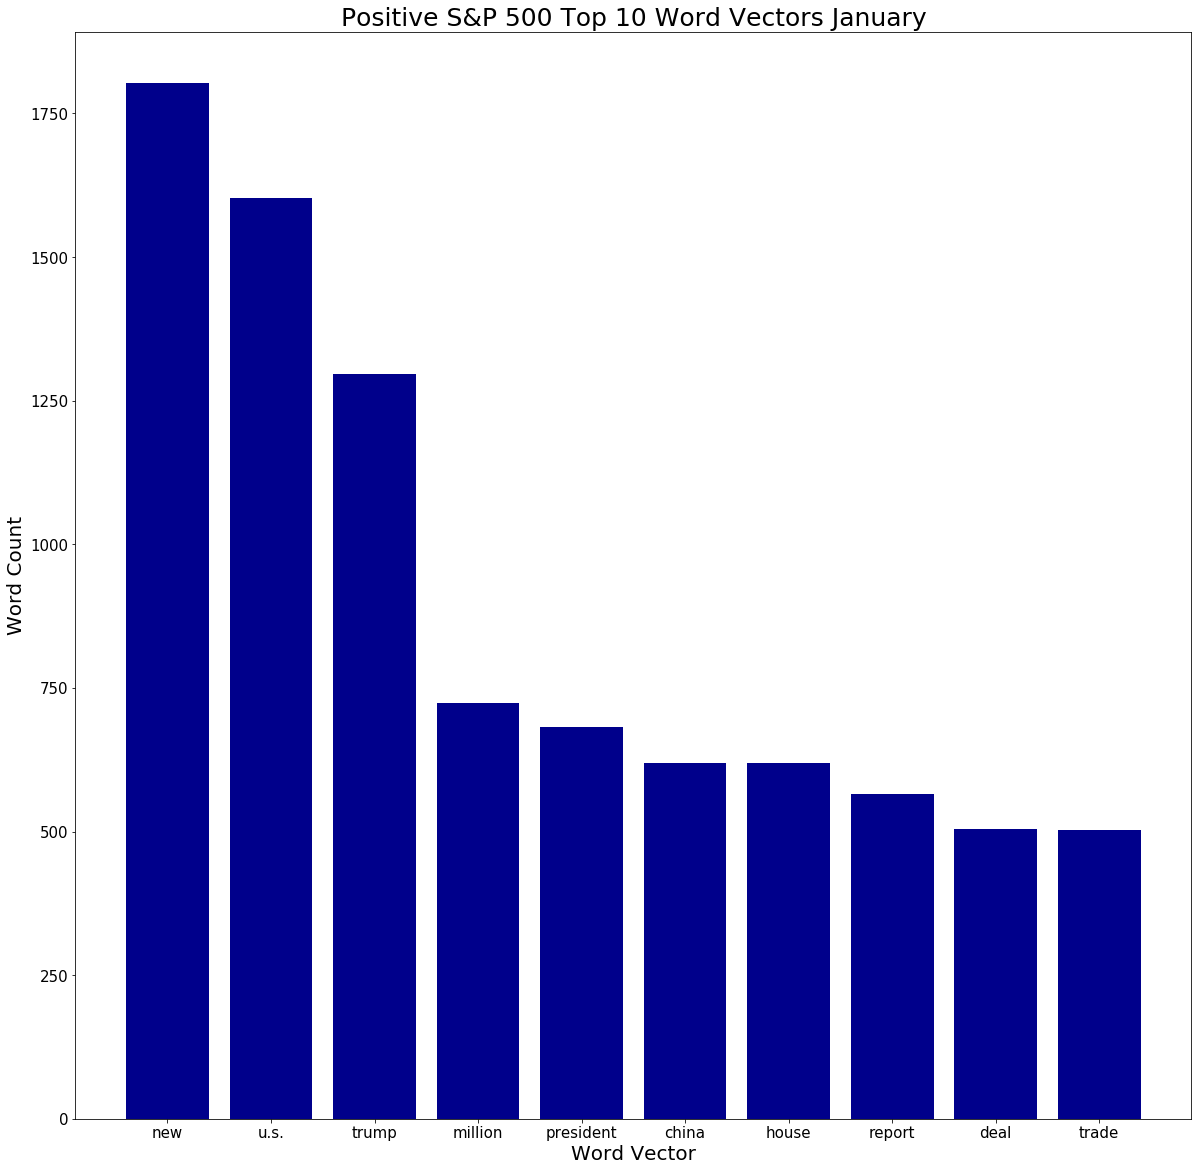

In [36]:
plt.figure(figsize=(20,20)) #Figsize
plt.bar(x=FreqDist_positive.keys(),
        height=FreqDist_positive.values(),
        color='darkblue') #Bar graph
plt.tick_params(labelsize=15)
plt.xlabel('Word Vector',size=20) #X label
plt.ylabel('Word Count',size=20) #Y label
plt.title('Positive S&P 500 Top 10 Word Vectors January', size=25) #Title

Text(0.5, 1.0, 'Negative S&P 500 Top 10 Word Vectors January')

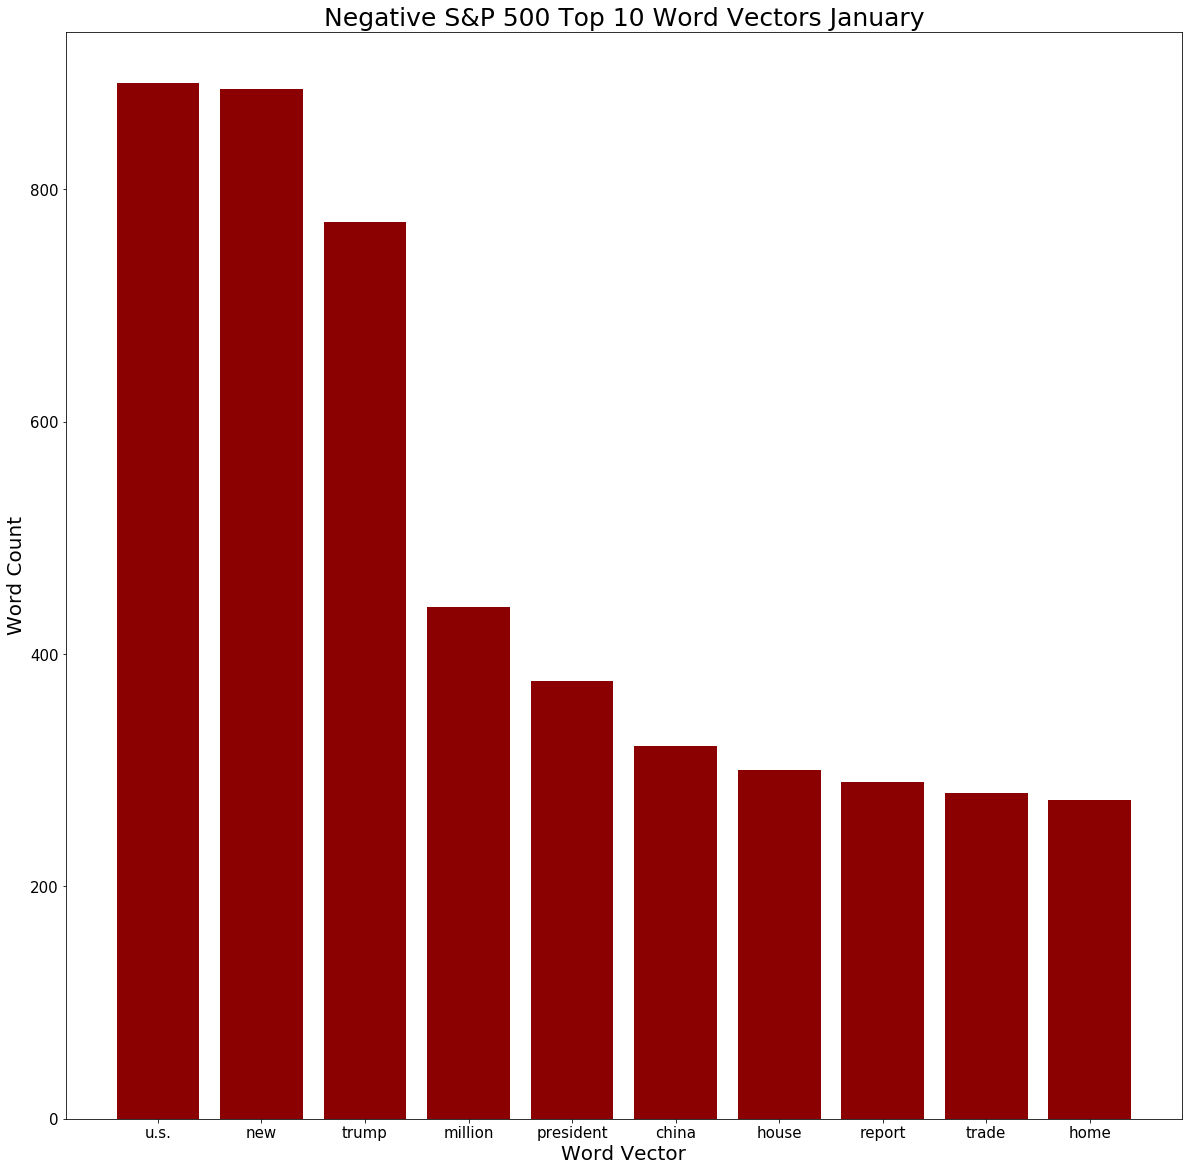

In [37]:
plt.figure(figsize=(20,20)) #Figsize
plt.bar(x=FreqDist_negative.keys(),
        height=FreqDist_negative.values(),
        color='darkred') #Bar graph
plt.tick_params(labelsize=15)
plt.xlabel('Word Vector',size=20) #X label
plt.ylabel('Word Count',size=20) #Y label
plt.title('Negative S&P 500 Top 10 Word Vectors January', size=25) #Title


As we can see from the above graphs there does not seem to be a difference really at all in the most common words for a positive SP500 day vs. a negative. In fact, the top words are exactly the same (except for the word home), but the word count values differ in order. The order is as follows:


Positive:
    
    1. new
    2. u.s
    3. trump
    4. million
    5. president
    6. china
    7. house
    8. report
    9. deal
    10. trade


Negative:  

    1. u.s
    2. new
    3. trump
    4. million
    5. president
    6. china
    7. house
    8. report
    9. trade
    10. home
Next lets dive into the whole data set to look at it's frequency distribution of words. 

In [38]:
tokenized_df=df['Text'].apply(nltk.word_tokenize)
df_tokens=[] 
for x in tokenized_df: #Stop word removal along with lower casing the tokens
    for y in x:
        if y not in stopwords_list:
            df_tokens.append(y.lower())

In [39]:
df_freq_dist=dict(FreqDist(df_tokens).most_common(10))

In [40]:
df_freq_dist

{'new': 2688,
 'u.s.': 2493,
 'trump': 2069,
 'million': 1163,
 'president': 1058,
 'china': 941,
 'house': 919,
 'report': 856,
 'trade': 782,
 'deal': 745}

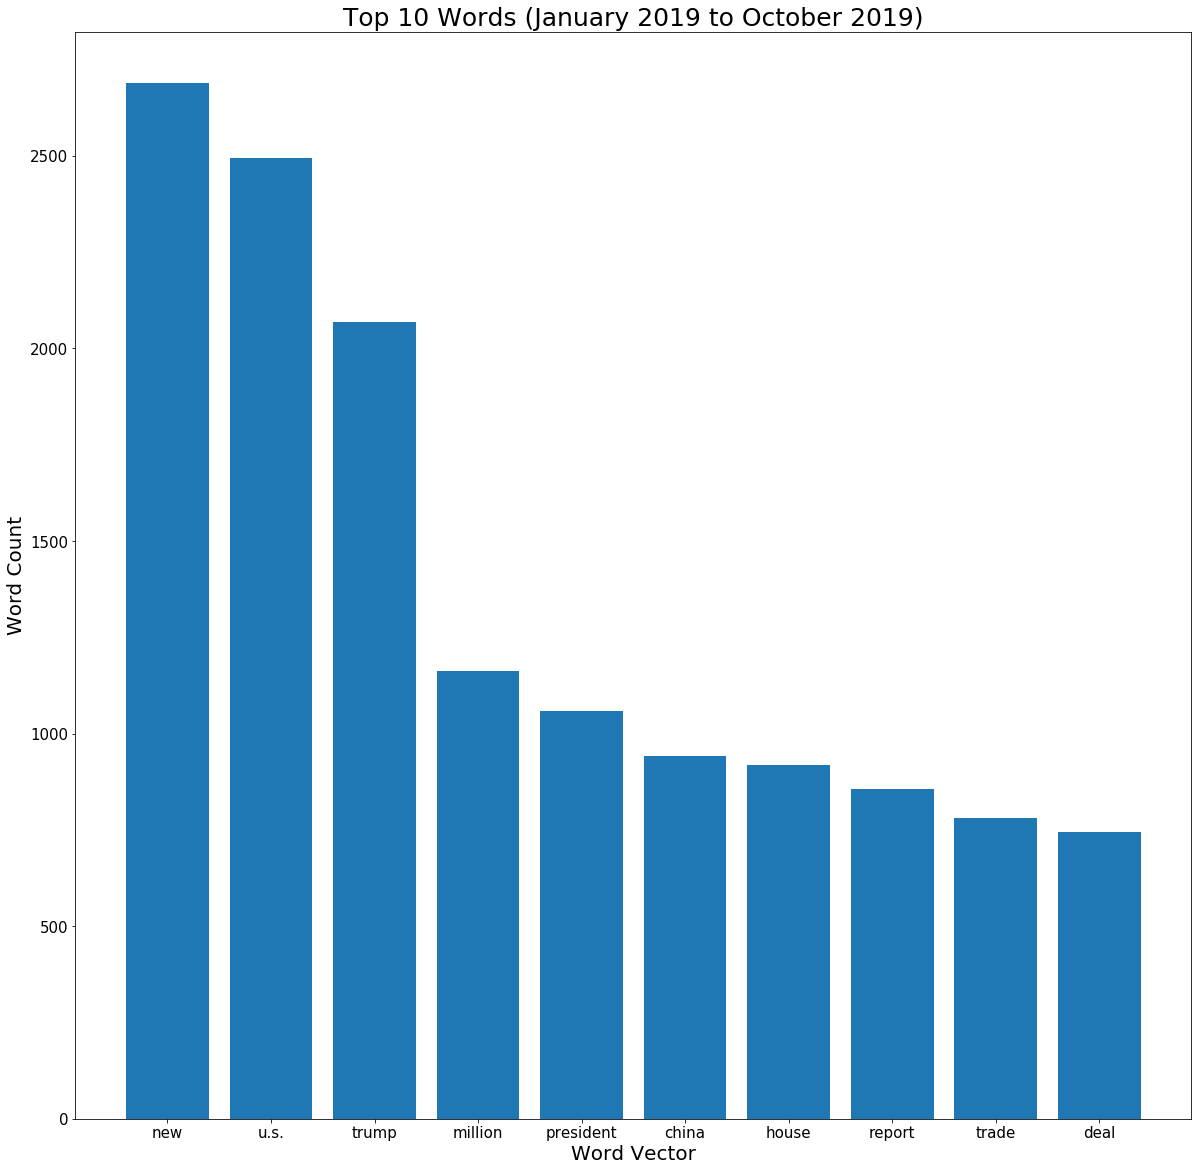

In [41]:
plt.figure(figsize=(20,20)) #Figsize
plt.bar(x=df_freq_dist.keys(),
        height=df_freq_dist.values()) #Bar graph
plt.tick_params(labelsize=15)
plt.xlabel('Word Vector',size=20) #X label
plt.ylabel('Word Count',size=20) #Y label
plt.title('Top 10 Words (January 2019 to October 2019)', size=25) #Title
plt.show()

We see the same exact words as the negative frequency distribution except for the word 'home' and the positive list has the word 'trade'. Some of the immediate thoughts and take aways from these graphs would be the general theme of US news over the past year. The day to day news and social media always is covering either Trump or China. Both of these topics make up the rest of the freq distribution word values.   

Side note: It would be very interesting to compare the frequency distribution of say the last year of Obamas presidency to see if his name ranks as highly as Trumps did. I believe the presidency will be covered and under as much scrutinity as Trump for the rest of US history. The biggest reason for this is due to the interconnectedness of the US due to social media and technology. 

Since Freq Dist word counts did not really show us all that much, I decided to get the actual values of the normalized frequency distribution for each word. 

In [192]:
df_tokens_freq_dist=FreqDist(df_tokens)
total_word_count = sum(df_tokens_freq_dist.values())
wsj_top_50 =df_tokens_freq_dist.most_common(50)
print("Word\t\t\tNormalized Frequency")
for word in wsj_top_50:
    normalized_frequency = word[1] / total_word_count
    print("{} \t{:.4}".format(word[0], normalized_frequency))

Word			Normalized Frequency
new 	0.008286
u.s. 	0.007685
trump 	0.006378
million 	0.003585
president 	0.003261
china 	0.002901
house 	0.002833
report 	0.002639
trade 	0.00241
deal 	0.002296
could 	0.002241
company 	0.002207
says 	0.002139
market 	0.002124
home 	0.00205
year 	0.002038
two 	0.001994
one 	0.001945
companies 	0.001942
first 	0.001914
week 	0.00188
stock 	0.001837
world 	0.001825
billion 	0.001819
former 	0.001816
big 	0.001782
fed 	0.001742
federal 	0.001695
york 	0.001683
business 	0.001674
state 	0.001612
would 	0.001578
people 	0.001566
u.s 	0.00156
sales 	0.00155
investors 	0.001547
growth 	0.001517
years 	0.00148
tech 	0.001464
chief 	0.001458
today 	0.001433
amazon 	0.001421
ceo 	0.001421
stocks 	0.00139
facebook 	0.00139
back 	0.001384
government 	0.001372
logistics 	0.001338
global 	0.001325
next 	0.001288


After looking at the most common words in the WSJ headline and subheaders, I have decided to take out says and said. I will add these to the stop words list.  
In addition, just a few observations:
    1. New, U.S, Trump are the most common words for both positive and negative SP 500 days.
    2. The only country besides the US that appeared in the bag of words was China. This is expected as over the past year a trade deal with China has been at the forefront of the American agenda. 
    3. The words report and house appear in all three charts. It is interesting that Mueller does not appear as well considering a lot of the report tokens I would imagine have to deal with the investigation conducted by Robert Muller.
    
Next I would like to do a little bit of EDA by further investigating the differences in the top 100 words between negative and positive changes in the SP 500. In addition, I would like to look into all the text that had report in it to see if my Robert Mueller hunch is correct.

## EDA Abs. Difference 

The following EDA is a absolute difference metric I created from the negative and positive frequency distributions. 

In [120]:
top_100_negative=dict(FreqDist(negative_tokens).most_common(100)) #Creating a dictionary of top 100 negative words

In [121]:
top_100_positive=dict(FreqDist(positive_tokens).most_common(100)) #Creating a dictionary of top 100 positive words

In [122]:
neg_100_df=pd.DataFrame.from_dict(top_100_negative, orient='index', columns=['Count']) #Dataframe creation

In [123]:
pos_100_df=pd.DataFrame.from_dict(top_100_positive, orient='index',columns=['Count']) #Dataframe creation

In [124]:
pos_and_neg=pd.merge(neg_100_df,pos_100_df,left_index=True,right_index=True) #Merging the two positive and negative dataframes

In [126]:
pos_and_neg.columns=['Negative','Positive'] #Renaming columns

In [127]:
pos_and_neg['Abs. Diff']= abs(pos_and_neg['Negative']-pos_and_neg['Positive']) #Creating absolute difference calculation

In [128]:
pos_and_neg.sort_values('Abs. Diff',ascending=False, inplace=True) #Sorting for highest absolute difference

In [236]:
pos_and_neg.head(25)

Negative  Positive  Abs. Diff
new             886      1802        916
u.s.            891      1602        711
trump           772      1297        525
house           300       619        319
president       377       681        304
china           321       620        299
million         440       723        283
report          290       566        276
deal            240       505        265
year            201       460        259
could           252       475        223
trade           280       502        222
two             214       433        219
amazon          123       338        215
one             209       422        213
week            199       411        212
tech            132       343        211
says            247       447        200
world           197       395        198
market          247       442        195
years           146       334        188
ceo             140       321        181
first           221       400        179
sales           163       340        177
company         270       446        176

88 of the top 100 positive change SP 500 days were also in the negative list. Now of these 88 I would like to do a absolute value to see which words have the most affect qoute on qoute.

Below is a graph of the above dataframe. Visually it represents the Positive vs. negative word frequency along with the absolute difference. One thing to note is the first company that has shown up through the analysis. Amazon, due to their new coveted HQ location selection proces, appeared quiet frequently over the past year.  

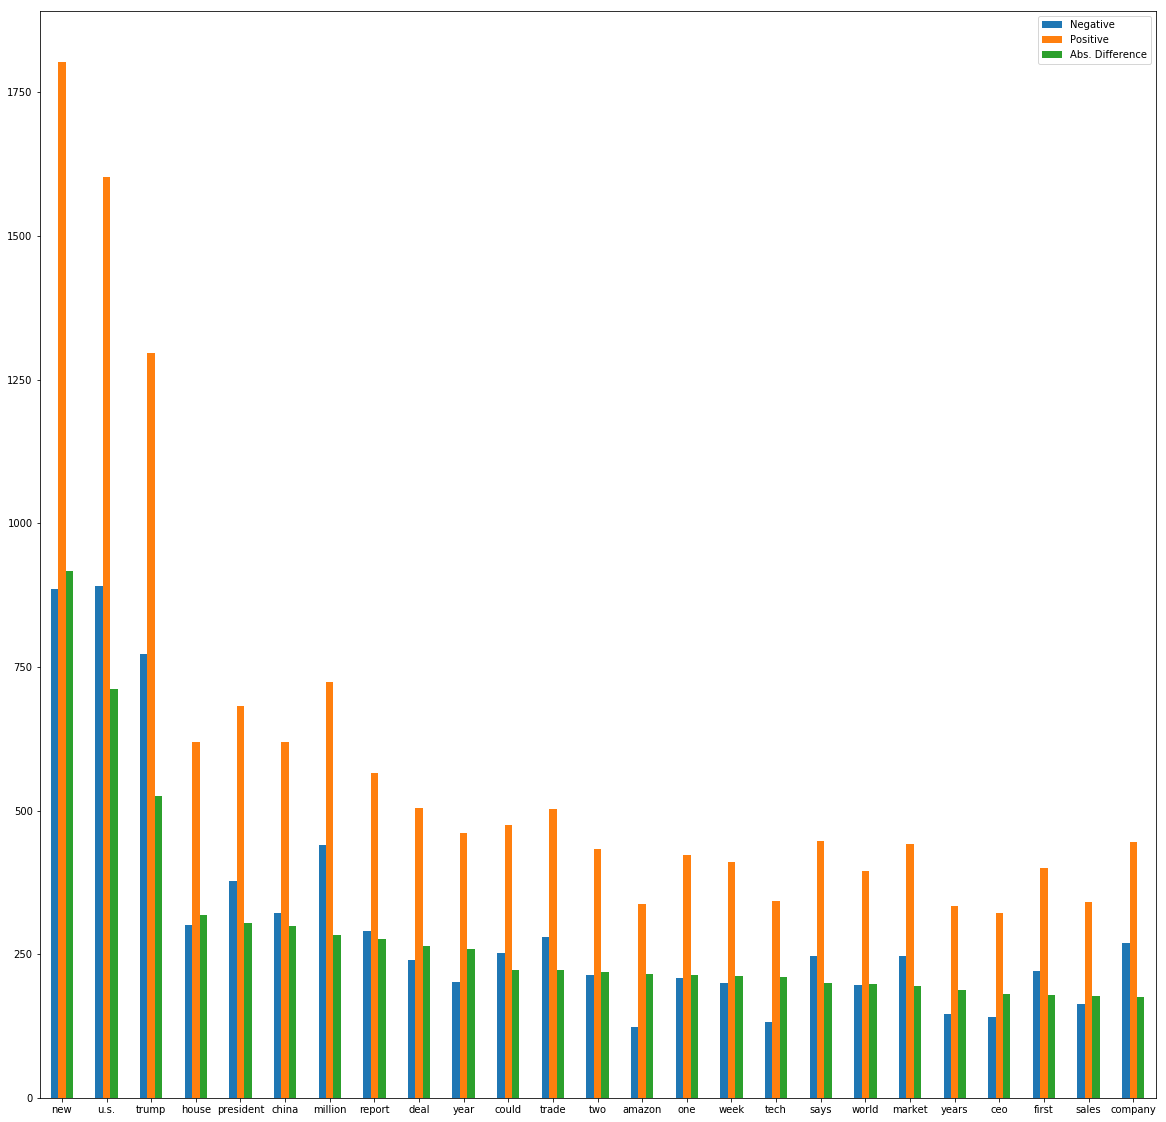

In [176]:
index = pos_and_neg.index[:25]
df_bar = pd.DataFrame({'Negative': pos_and_neg['Negative'][:25], 'Positive': pos_and_neg['Positive'][:25], 'Abs. Difference': pos_and_neg['Abs. Diff'][:25]}, index=index)
ax = df_bar.plot.bar(rot=0,figsize=(20,20))

## EDA Word Clouds

A very visually appealing way to display text data is through word clouds. I decided to do a word cloud for all of the data. Below is the result.

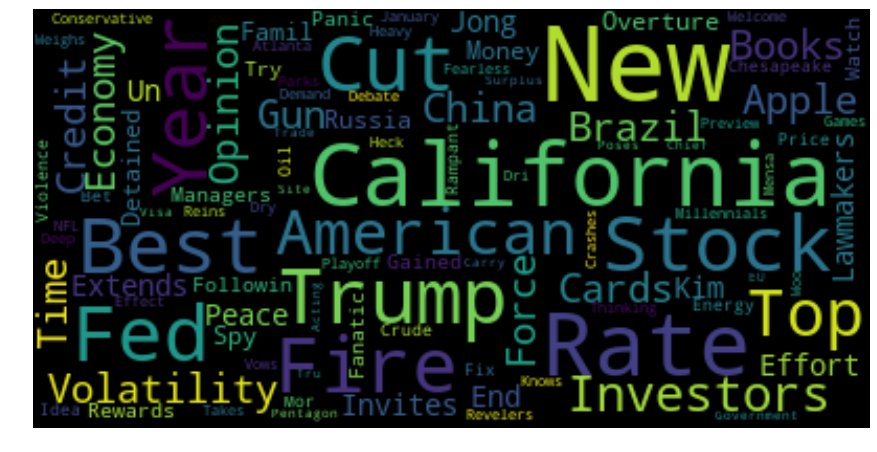

In [128]:
text= str(df['Text']) #Changing data type to easily integrate with wordcloud pakcage

wordcloud = WordCloud(stopwords=stopwords_list,max_font_size=50, max_words=100, background_color="black").generate(str(text)) #Creating wordcloud

# Display the generated image:
plt.figure(figsize=(15,15)) #figsize
plt.imshow(wordcloud, interpolation='bilinear') 
plt.axis("off")
plt.show()

Top words seem to be American, Trump, Fire, California, Rate, Brazil, etc. This is very interesting considering almost every word on here can be linked to a general year long topic that has constantly beent talked about. 

For example, California and their wild fires has been all over the news the past two years. In addition, Fed and Rate bouth show up which is in regards to the federal reserve and their rate increases or cuts. Note, Apple is the only company that showed up in this word cloud which is very interesting. So far only Apple and Amazon have showed up. May be interesting to do some more research into both of their stock prices in regards to negative and positive SP500 market days. 

Another cool representation of the text is by using a pre-existing image and then overlay your wordclouds in said image. Below is my attempt at this through using a WSJ image I found off of google. 

In [198]:
wsj_mask= np.array(Image.open(r'C:\Users\GBLS\Desktop\wsj-social-share.png')) #importing image

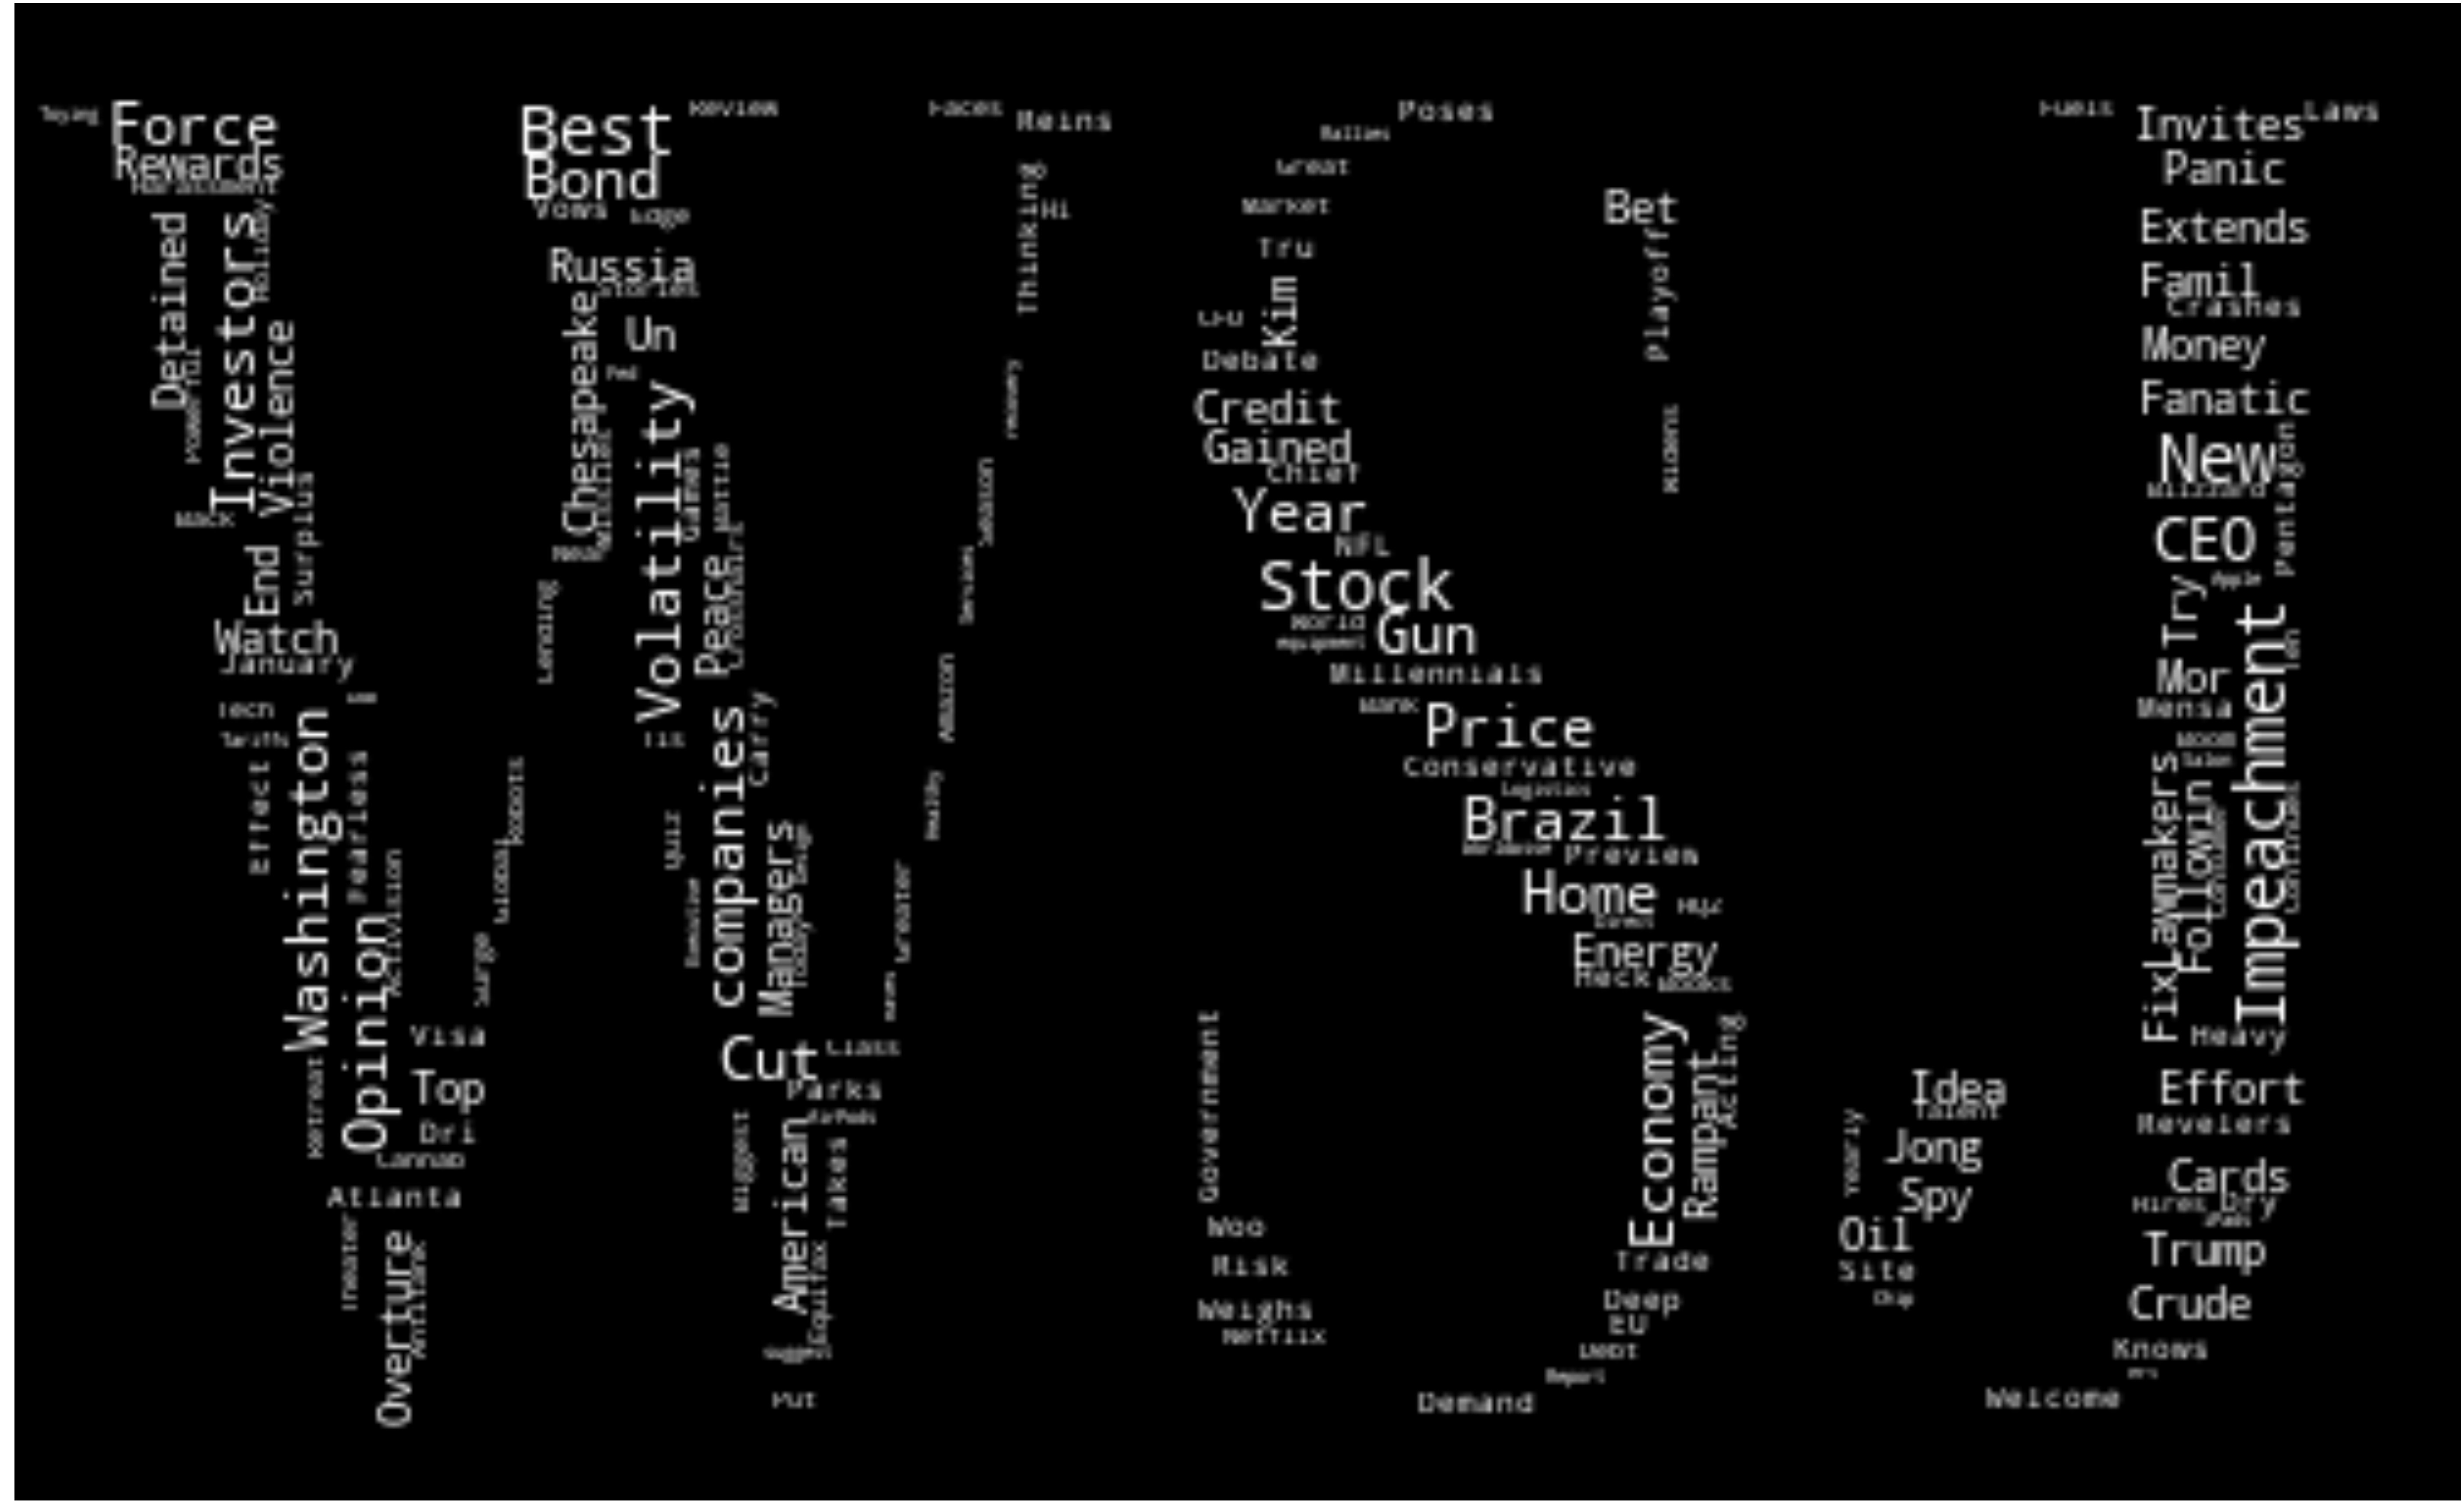

In [200]:
text= df['Text']

wordcloud = WordCloud(stopwords=stopwords_list, max_words=200, background_color="black",mask=wsj_mask, color_func=(lambda *args, **kwargs: "white")).generate(str(text))

# Display the generated image:
plt.figure(figsize=(100,100))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## EDA Time Series Modeling

This section is just a quick look into a bit of time series modeling of the SP500 over the last year. Figured this would be a nice visual to show how part of the economy has performed over the past year. 

In [205]:
sp_500=pd.read_csv('S&P 500 Data.csv') #df read

In [211]:
sp_500.set_index(sp_500['Date'],inplace=True) #Date Time index setting

In [215]:
sp_500.drop(['Date'],axis=1,inplace=True) #Dropping Date column

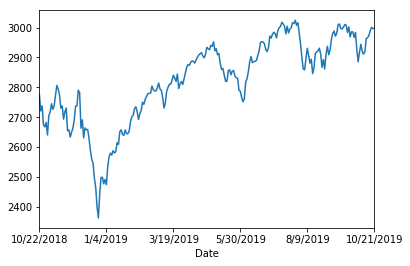

In [222]:
sp_500['Open'].plot() #Time series 

Decided to take the close of each day and subtract the open, it appears from the graph below the data is very stationary when you do this. 

In [225]:
sp_500['Change']=sp_500['Close']-sp_500['Open']

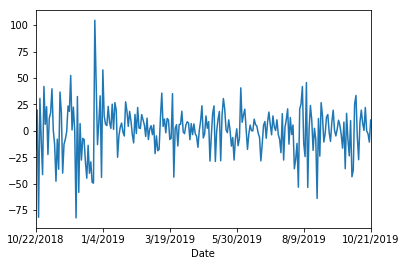

In [226]:
sp_500['Change'].plot()

# Modeling

### Baseline Model

In [ ]:
X=df['Text'] #Splitting into X and y variables
y=df['Coded']

sent_train, sent_test, y_train, y_test = train_test_split(X,y, test_size=.25, random_state=1) #Train test split

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer= CountVectorizer() #Vectorization object
vectorizer.fit(sent_train)

X_train= vectorizer.transform(sent_train) #transforming vectors
X_test= vectorizer.transform(sent_test) #transforming vectors

In [ ]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression() #Classifier
classifier.fit(X_train, y_train) #Fitting model
score = classifier.score(X_test, y_test) #Accuracy Score

print("Accuracy:", score)

Basic tokenization was used and achieved accuracy of 64 percent. The two paths forward are as follow: make the model more complex or tokenize the words differently by using bigrams or lemmentization. Hopefully, by isolating the models and only tweaking one aspect of the data/moddel we will improve our accuracy.

First I am going to try to change the tokenized inputs of the models:
    1. Stemming and Lemmentization
    2. Bigrams

## Stemming and Lemmentization

In [35]:
df.head() #Loading original dataframe

Date                                               Text  Change  \
0  2019-01-01  Trump Invites Top Lawmakers in Effort To End S...     1.0   
1  2019-01-01         Kim Jong Un Extends Peace Overture to U.S.     1.0   
2  2019-01-01  American Detained in Russia Isn’t a Spy, Famil...     1.0   
3  2019-01-01                The Money Managers to Watch in 2019     1.0   
4  2019-01-01   Investors Try Not to Panic Over Stock Volatility     1.0   

   Coded    Token  
0    1.0  learned  
1    1.0  learned  
2    1.0  learned  
3    1.0  learned  
4    1.0  learned

In [36]:
stemmer = PorterStemmer() #Creating the PorterStemmer
stemmed_words= [stemmer.stem(token) for token in df_tokens] #Stemming the tokens

In [37]:
FreqDist(stemmed_words).most_common()

[('new', 2688),
 ('u.s.', 2493),
 ('trump', 2073),
 ('compani', 1346),
 ('million', 1261),
 ('year', 1141),
 ('presid', 1089),
 ('say', 1088),
 ('report', 1082),
 ('hous', 1069),
 ('stock', 1049),
 ('market', 1026),
 ('trade', 948),
 ('china', 941),
 ('plan', 904),
 ('deal', 861),
 ('home', 809),
 ('could', 727),
 ('week', 719),
 ('get', 703),
 ('busi', 688),
 ('make', 669),
 ('democrat', 659),
 ('billion', 658),
 ('state', 656),
 ('sale', 651),
 ('one', 649),
 ('two', 647),
 ('take', 638),
 ('first', 621),
 ('investor', 617),
 ('bank', 603),
 ('world', 597),
 ('rate', 592),
 ('face', 589),
 ('former', 589),
 ('price', 586),
 ('big', 578),
 ('feder', 573),
 ('fed', 570),
 ('offici', 546),
 ('sell', 546),
 ('york', 546),
 ('back', 545),
 ('govern', 537),
 ('cut', 536),
 ('execut', 533),
 ('like', 523),
 ('citi', 516),
 ('would', 512),
 ('peopl', 509),
 ('ceo', 508),
 ('u.', 506),
 ('help', 504),
 ('move', 503),
 ('chief', 501),
 ('buy', 498),
 ('ad', 497),
 ('growth', 492),
 ('fund', 48

There really is not a difference between the stemmed words vs. the traditional tokenized word counts. Now lets run a model to see if this had any effect on the modeling accuracy.

In [43]:
def stemming_tokenizer(str_input): #Defining a function to be able to load this into our model as the tokenizer
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    words = [PorterStemmer().stem(word) for word in words]
    return words

In [44]:
X=df['Text']
y=df['Coded']

sent_train, sent_test, y_train, y_test = train_test_split(X,y, test_size=.25, random_state=1)

vectorizer= CountVectorizer(tokenizer=stemming_tokenizer) #Everything else is the same as passed models, except tweaking tokenizer
vectorizer.fit(sent_train)

X_train= vectorizer.transform(sent_train)
X_test= vectorizer.transform(sent_test)

In [108]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", round(score*100,2),'%')

Accuracy: 64.93 %


As we see here, stemming did not improve our model by very much. Essentially it improved by a little under a percentage point. 

In [80]:
def word_lemmatization(text):
    return lemmatizer.lemmatize(text)
    

In [94]:
lemmatized= []
for x in df_tokens:
    lemmatized.append(lemmatizer.lemmatize(x))

In [95]:
lemmatized

['trump',
 'invite',
 'top',
 'lawmaker',
 'effort',
 'end',
 'shutdown',
 'kim',
 'jong',
 'un',
 'extends',
 'peace',
 'overture',
 'u.s',
 'american',
 'detained',
 'russia',
 'spy',
 'family',
 'say',
 'money',
 'manager',
 'watch',
 '2019',
 'investor',
 'try',
 'panic',
 'stock',
 'volatility',
 'reward',
 'credit',
 'card',
 'gained',
 'fanatic',
 'following—now',
 'bank',
 'pulling',
 'back',
 'chesapeake',
 'energy',
 'bet',
 'oil',
 'crude',
 'price',
 'plunged',
 'brazil',
 'idea',
 'fix',
 'rampant',
 'gun',
 'violence',
 'gun',
 'conservative',
 'take',
 'rein',
 'brazil',
 'vow',
 'restore',
 'order',
 'woo',
 'millennials',
 'atlanta',
 'weighs',
 'park',
 'highway',
 'dry',
 'january',
 'effect',
 'reveler',
 'welcome',
 '2019',
 'fearless',
 'nfl',
 'playoff',
 'preview',
 'heck',
 'know',
 'mensa',
 'debate',
 'deep',
 'thinking',
 'game',
 'drinking',
 'heavy',
 'demand',
 'crash',
 'government',
 'visa',
 'site',
 'acting',
 'pentagon',
 'chief',
 'say',
 'carry',
 

In [100]:
def lemmatizeration(x):
    for x in df_tokens:
        word= []
        word.append(lemmatizer.lemmatize(x))
        return word

In [123]:
X=df['Text']
y=df['Coded']

sent_train, sent_test, y_train, y_test = train_test_split(X,y, test_size=.25, random_state=1)

vectorizer= CountVectorizer(tokenizer=lemmatizeration)
vectorizer.fit(sent_train)

X_train= vectorizer.transform(sent_train)
X_test= vectorizer.transform(sent_test)

In [124]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", round(score*100,2),'%')

Accuracy: 64.93 %


Lemmatizing the text gave us a identical result to stemming. I am not confident that changing the mode of text will help the model, but I will try one last strategy, Bigrams. 

## Bigrams

Another strategy for tokenizing is using bigrams, which are words that essentailly belong or show up together in sentances. The computer is able to recongnize which words belong together and which ones do not. Below is the analysis of the bigrams. 

In [196]:
bigram_measures = nltk.collocations.BigramAssocMeasures() #Bigrams created and scored
wsj_finder = BigramCollocationFinder.from_words(df_tokens)
wsj_scored = wsj_finder.score_ngrams(bigram_measures.raw_freq)
wsj_scored[:50]

[(('president', 'trump'), 0.0017477505802716874),
 (('new', 'york'), 0.0016830190772986618),
 (('logistics', 'report'), 0.0009216533042349815),
 (('today', 'logistics'), 0.0009216533042349815),
 (('trump', 'administration'), 0.0009154883991899314),
 (('hong', 'kong'), 0.0008939112315322563),
 (('white', 'house'), 0.0008939112315322563),
 (('wall', 'street'), 0.0006473150297302546),
 (('morning', 'risk'), 0.0006010782418923793),
 (('risk', 'report'), 0.0006010782418923793),
 (('737', 'max'), 0.0005579239065770289),
 (('morning', 'download'), 0.0004901099510814785),
 (('york', 'city'), 0.0004746976884688534),
 (('supreme', 'court'), 0.0004407907107210781),
 (('prime', 'minister'), 0.0004315433531535031),
 (('great', 'escapes'), 0.000422295995585928),
 (('justice', 'department'), 0.00040380128045077785),
 (('last', 'year'), 0.0003791416602705777),
 (('north', 'korea'), 0.0003760592077480527),
 (('paid', 'program'), 0.00037297675522552764),
 (('pg', 'e'), 0.0003575644926129025),
 (('federa

PMI score: measure of association used in information theory and statistics referring to single events.

Below are the calculations and code for this. It is very interesting due to the fact that it can call out important events that have happened over the year. 

In [197]:
wsj_pmi_finder = BigramCollocationFinder.from_words(df_tokens)
wsj_pmi_finder.apply_freq_filter(5)
wsj_pmi_scored = wsj_pmi_finder.score_ngrams(bigram_measures.pmi)
wsj_pmi_scored

[(('abdelaziz', 'bouteflika'), 15.985561800747938),
 (('clayton', 'kershaw'), 15.985561800747938),
 (('edith', 'wharton'), 15.985561800747938),
 (('f.h', 'bertling'), 15.985561800747938),
 (('fire-', 'paparazzi-proofed'), 15.985561800747938),
 (('harriet', 'tubman'), 15.985561800747938),
 (('history—and', 'odds—are'), 15.985561800747938),
 (('javad', 'zarif'), 15.985561800747938),
 (('johns', 'hopkins'), 15.985561800747938),
 (('karlie', 'kloss'), 15.985561800747938),
 (('kershaw', 'fastball'), 15.985561800747938),
 (('lil', 'nas'), 15.985561800747938),
 (('lópez', 'obrador'), 15.985561800747938),
 (('nipsey', 'hussle'), 15.985561800747938),
 (('questions—and', 'answers—coming'), 15.985561800747938),
 (('randall', 'stephenson'), 15.985561800747938),
 (('sous', 'vide'), 15.985561800747938),
 (('triple—or', 'better—in'), 15.985561800747938),
 (('abn', 'amro'), 15.722527394914142),
 (('achilles', 'tendon'), 15.722527394914142),
 (('andrés', 'manuel'), 15.722527394914142),
 (('b-12', 'defi

1. Abdelaziz Bouteflika: He was the President of Algeria and in 2019 he was removed from office by stepping down due to mass protests. 
2. Clayton Kershaw: A pitcher for the Los Angeles Dodgers who has struggled as of late in the post season. 
3. Nipsey Hussel: Famous Compton rapper who was killed in broad day light outside of his Marathon store. This was a huge deal for the rap and music community and touched many peopls hearts. 
4. Achilles Temdpm: Most likely in reference to the many athletes over 2019 that had achilles injuries. Just to name a few: John Wall, Kevin Durant, Dez Bryant

### Modeling with Bigrams

In [112]:
X=df['Text'] #X and y declared
y=df['Coded']

sent_train, sent_test, y_train, y_test = train_test_split(X,y, test_size=.25, random_state=1) #Train test split

vectorizer= CountVectorizer(ngram_range=(2,2), stop_words='english') #Passing in bigram arguement
vectorizer.fit(sent_train)

X_train= vectorizer.transform(sent_train)
X_test= vectorizer.transform(sent_test)

In [113]:
classifier = LogisticRegression() #Defining and fiting the classifier
classifier.fit(X_train, y_train)
score = classifier.score(X_test, y_test)

print("Accuracy:", round(score*100,2),'%')

C:\Users\GBLS\AppData\Local\Continuum\anaconda3\New folder\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy: 69.08 %


The bigrams did in fact improve our model by around 4 or 5 percent! The next step is to use neural networks and other more advanced modeling techniques. The following sections will focus on this. I am hoping to get at least a 5-10 percent increase in accuracy.

## Neural Network 

The highest accuracy so far came from our last model, using bigrams and logistic regression. I want to try to implement a bit more complex models in the hope to improve our accruacy substantially. First I will start with a basic neural network.

In [3]:
df=pd.read_csv('January-October') #loading Data

In [23]:
MAX_NB_WORDS = 5000 # Max number of word
MAX_SEQUENCE_LENGTH = 250 # This is fixed.
EMBEDDING_DIM = 100

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True) #Tokenizer intialization
tokenizer.fit_on_texts(df['Text'])
word_index = tokenizer.word_index #Tokenizing into index
print('Found %s unique tokens.' % len(word_index))

Found 27479 unique tokens.


In [24]:
X = tokenizer.texts_to_sequences(df['Text']) #Putting data into data tensor with padding to be able to feed into model
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (35938, 250)


In [25]:
Y = pd.get_dummies(df['Coded']) #one hot dummy encoding for y labeling purposes 
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (35938, 2)


In [26]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42) #train test split
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(28750, 250) (28750, 2)
(7188, 250) (7188, 2)


In [20]:
# plt.title('Loss')
# plt.plot(history.history['loss'], label='train')
# plt.plot(history.history['val_loss'], label='test')
# plt.legend()
# plt.show();

In [21]:
# plt.title('Accuracy')
# plt.plot(history.history['acc'], label='train')
# plt.plot(history.history['val_acc'], label='test')
# plt.legend()
# plt.show();

In [17]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

IndexError: tuple index out of range

In [195]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Train on 29109 samples, validate on 3235 samples
Epoch 1/5
29109/29109 [==============================] - 327s 11ms/step - loss: 0.6469 - acc: 0.6522 - val_loss: 0.6444 - val_acc: 0.6402
Epoch 2/5
29109/29109 [==============================] - 322s 11ms/step - loss: 0.5751 - acc: 0.7037 - val_loss: 0.6437 - val_acc: 0.6431
Epoch 3/5
29109/29109 [==============================] - 316s 11ms/step - loss: 0.4560 - acc: 0.7896 - val_loss: 0.6920 - val_acc: 0.6524
Epoch 4/5
29109/29109 [==============================] - 317s 11ms/step - loss: 0.3685 - acc: 0.8356 - val_loss: 0.8093 - val_acc: 0.6413
Epoch 5/5
29109/29109 [==============================] - 321s 11ms/step - loss: 0.3047 - acc: 0.8631 - val_loss: 0.8877 - val_acc: 0.6564


In [196]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

3594/3594 [==============================] - 5s 1ms/step
Test set
  Loss: 0.931
  Accuracy: 0.648


We see that we have a very high loss which means we are overfitting as the training data has max accuracy of 86 percent but the highest valadation accuracy is 65%. I am going to reduce the max number of words to try to narrow down our data to the most imporant words. 

In [15]:
MAX_NB_WORDS=2500 #Reducing max numbder of words

In [16]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True) #Rerunning to fit ot model
tokenizer.fit_on_texts(df['Text'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 27479 unique tokens.


In [27]:
X = tokenizer.texts_to_sequences(df['Text']) #Rerunning for the lesser max_NB_WORDS variable
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
Y = pd.get_dummies(df['Coded'])
print('Shape of label tensor:', Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Shape of data tensor: (35938, 250)
Shape of label tensor: (35938, 2)
(28750, 250) (28750, 2)
(7188, 250) (7188, 2)


In [28]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 250, 100)          250000    
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_20 (Dense)             (None, 8)                 808       
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 18        
Total params: 331,226
Trainable params: 331,226
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Train on 25875 samples, validate on 2875 samples
Epoch 1/5
25875/25875 [==============================] - 234s 9ms/step - loss: 0.6468 - acc: 0.6520 - val_loss: 0.6543 - val_acc: 0.6390
Epoch 2/5
25875/25875 [==============================] - 239s 9ms/step - loss: 0.6256 - acc: 0.6578 - val_loss: 0.6533 - val_acc: 0.6376
Epoch 3/5
25875/25875 [==============================] - 239s 9ms/step - loss: 0.5965 - acc: 0.6833 - val_loss: 0.6709 - val_acc: 0.6235
Epoch 4/5
25875/25875 [==============================] - 239s 9ms/step - loss: 0.5754 - acc: 0.7022 - val_loss: 0.6826 - val_acc: 0.6235
Epoch 5/5
25875/25875 [==============================] - 237s 9ms/step - loss: 0.5523 - acc: 0.7210 - val_loss: 0.6972 - val_acc: 0.6210


In [30]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7188/7188 [==============================] - 12s 2ms/step
Test set
  Loss: 0.687
  Accuracy: 0.636


We see that this substantially brought down the loss score to .687 which is around .244 lower. This is a step in a right direction. I would like to add another layer to see how this affects the metrics. 

In [31]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 250, 100)          250000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_22 (Dense)             (None, 16)                1616      
_________________________________________________________________
dense_23 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_24 (Dense)             (None, 2)                 18        
Total params: 332,170
Trainable params: 332,170
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Train on 25875 samples, validate on 2875 samples
Epoch 1/5
25875/25875 [==============================] - 383s 15ms/step - loss: 0.6470 - acc: 0.6521 - val_loss: 0.6514 - val_acc: 0.6393
Epoch 2/5
25875/25875 [==============================] - 471s 18ms/step - loss: 0.6250 - acc: 0.6568 - val_loss: 0.6539 - val_acc: 0.6327
Epoch 3/5
25875/25875 [==============================] - 487s 19ms/step - loss: 0.5959 - acc: 0.6805 - val_loss: 0.6637 - val_acc: 0.6191
Epoch 4/5
25875/25875 [==============================] - 481s 19ms/step - loss: 0.5738 - acc: 0.7005 - val_loss: 0.6722 - val_acc: 0.6214
Epoch 5/5
25875/25875 [==============================] - 476s 18ms/step - loss: 0.5521 - acc: 0.7178 - val_loss: 0.6958 - val_acc: 0.6162


In [33]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7188/7188 [==============================] - 16s 2ms/step
Test set
  Loss: 0.690
  Accuracy: 0.625


This did not help either of our metrics and ended up decreasing the accuracy and increasing the loss slightly. 

In [34]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 250, 100)          250000    
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_25 (Dense)             (None, 32)                3232      
_________________________________________________________________
dense_26 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_27 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_28 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_29 (Dense)             (None, 2)                

In [35]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Train on 25875 samples, validate on 2875 samples
Epoch 1/5
25875/25875 [==============================] - 486s 19ms/step - loss: 0.6500 - acc: 0.6488 - val_loss: 0.6554 - val_acc: 0.6390
Epoch 2/5
25875/25875 [==============================] - 466s 18ms/step - loss: 0.6385 - acc: 0.6526 - val_loss: 0.6556 - val_acc: 0.6390
Epoch 3/5
25875/25875 [==============================] - 467s 18ms/step - loss: 0.6168 - acc: 0.6575 - val_loss: 0.6554 - val_acc: 0.6162
Epoch 4/5
25875/25875 [==============================] - 482s 19ms/step - loss: 0.5950 - acc: 0.6799 - val_loss: 0.6737 - val_acc: 0.6092
Epoch 5/5
25875/25875 [==============================] - 510s 20ms/step - loss: 0.5747 - acc: 0.6974 - val_loss: 0.6881 - val_acc: 0.6123


In [36]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7188/7188 [==============================] - 17s 2ms/step
Test set
  Loss: 0.680
  Accuracy: 0.624


Adjusting the LSTM

In [37]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='relu'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 250, 100)          250000    
_________________________________________________________________
lstm_9 (LSTM)                (None, 256)               365568    
_________________________________________________________________
dense_30 (Dense)             (None, 8)                 2056      
_________________________________________________________________
dense_31 (Dense)             (None, 2)                 18        
Total params: 617,642
Trainable params: 617,642
Non-trainable params: 0
_________________________________________________________________
None


In [38]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Train on 25875 samples, validate on 2875 samples
Epoch 1/5
25875/25875 [==============================] - 1036s 40ms/step - loss: 0.6478 - acc: 0.6525 - val_loss: 0.6531 - val_acc: 0.6390
Epoch 2/5
25875/25875 [==============================] - 903s 35ms/step - loss: 0.6213 - acc: 0.6614 - val_loss: 0.6520 - val_acc: 0.6287
Epoch 3/5
25875/25875 [==============================] - 710s 27ms/step - loss: 0.5950 - acc: 0.6856 - val_loss: 0.6654 - val_acc: 0.6186
Epoch 4/5
25875/25875 [==============================] - 608s 24ms/step - loss: 0.5727 - acc: 0.7037 - val_loss: 0.6794 - val_acc: 0.6083
Epoch 5/5
25875/25875 [==============================] - 607s 23ms/step - loss: 0.5504 - acc: 0.7209 - val_loss: 0.7005 - val_acc: 0.6233


In [39]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7188/7188 [==============================] - 67s 9ms/step
Test set
  Loss: 0.695
  Accuracy: 0.629


Further reducing the number of words used. 

CHANGED BACK TO 5000 words

In [32]:
MAX_NB_WORDS=2500
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['Text'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
X = tokenizer.texts_to_sequences(df['Text'])
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)
Y = pd.get_dummies(df['Coded'])
print('Shape of label tensor:', Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

Found 27479 unique tokens.
Shape of data tensor: (35938, 250)
Shape of label tensor: (35938, 2)
(28750, 250) (28750, 2)
(7188, 250) (7188, 2)


In [33]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(120, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 250, 100)          250000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 120)               106080    
_________________________________________________________________
dense_11 (Dense)             (None, 8)                 968       
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 18        
Total params: 357,066
Trainable params: 357,066
Non-trainable params: 0
_________________________________________________________________
None


In [34]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Train on 25875 samples, validate on 2875 samples
Epoch 1/5
  384/25875 [..............................] - ETA: 4:39 - loss: 0.8002 - acc: 0.3503

KeyboardInterrupt: 

In [47]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7188/7188 [==============================] - 31s 4ms/step
Test set
  Loss: 0.659
  Accuracy: 0.632


In [48]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(120, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 250, 100)          250000    
_________________________________________________________________
lstm_12 (LSTM)               (None, 120)               106080    
_________________________________________________________________
dense_36 (Dense)             (None, 16)                1936      
_________________________________________________________________
dense_37 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_38 (Dense)             (None, 2)                 18        
Total params: 358,170
Trainable params: 358,170
Non-trainable params: 0
_________________________________________________________________
None


In [49]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Train on 25875 samples, validate on 2875 samples
Epoch 1/5
25875/25875 [==============================] - 669s 26ms/step - loss: 0.6514 - acc: 0.6426 - val_loss: 0.6544 - val_acc: 0.6390
Epoch 2/5
25875/25875 [==============================] - 552s 21ms/step - loss: 0.6459 - acc: 0.6526 - val_loss: 0.6544 - val_acc: 0.6390
Epoch 3/5
25875/25875 [==============================] - 495s 19ms/step - loss: 0.6459 - acc: 0.6526 - val_loss: 0.6548 - val_acc: 0.6390
Epoch 4/5
25875/25875 [==============================] - 543s 21ms/step - loss: 0.6460 - acc: 0.6526 - val_loss: 0.6552 - val_acc: 0.6390
Epoch 5/5
25875/25875 [==============================] - 641s 25ms/step - loss: 0.6460 - acc: 0.6526 - val_loss: 0.6546 - val_acc: 0.6390


In [50]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7188/7188 [==============================] - 31s 4ms/step
Test set
  Loss: 0.647
  Accuracy: 0.651


In [51]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(120, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(24, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 250, 100)          250000    
_________________________________________________________________
lstm_13 (LSTM)               (None, 120)               106080    
_________________________________________________________________
dense_39 (Dense)             (None, 24)                2904      
_________________________________________________________________
dense_40 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_41 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_42 (Dense)             (None, 2)                 18        
Total params: 359,538
Trainable params: 359,538
Non-trainable params: 0
_______________________________________________

In [52]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Train on 25875 samples, validate on 2875 samples
Epoch 1/5
25875/25875 [==============================] - 653s 25ms/step - loss: 0.6551 - acc: 0.6339 - val_loss: 0.6552 - val_acc: 0.6390
Epoch 2/5
25875/25875 [==============================] - 664s 26ms/step - loss: 0.6459 - acc: 0.6526 - val_loss: 0.6546 - val_acc: 0.6390
Epoch 3/5
25875/25875 [==============================] - 664s 26ms/step - loss: 0.6459 - acc: 0.6526 - val_loss: 0.6542 - val_acc: 0.6390
Epoch 4/5
25875/25875 [==============================] - 659s 25ms/step - loss: 0.6460 - acc: 0.6526 - val_loss: 0.6543 - val_acc: 0.6390
Epoch 5/5
25875/25875 [==============================] - 486s 19ms/step - loss: 0.6459 - acc: 0.6526 - val_loss: 0.6546 - val_acc: 0.6390


In [53]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7188/7188 [==============================] - 21s 3ms/step
Test set
  Loss: 0.647
  Accuracy: 0.651


In [54]:
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(LSTM(120, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(24, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_14 (Embedding)     (None, 250, 100)          250000    
_________________________________________________________________
lstm_14 (LSTM)               (None, 120)               106080    
_________________________________________________________________
dense_43 (Dense)             (None, 32)                3872      
_________________________________________________________________
dense_44 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_45 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_46 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_47 (Dense)             (None, 2)               

In [55]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Train on 25875 samples, validate on 2875 samples
Epoch 1/5
25875/25875 [==============================] - 329s 13ms/step - loss: 0.6517 - acc: 0.6373 - val_loss: 0.6542 - val_acc: 0.6390
Epoch 2/5
25875/25875 [==============================] - 347s 13ms/step - loss: 0.6460 - acc: 0.6526 - val_loss: 0.6554 - val_acc: 0.6390
Epoch 3/5
25875/25875 [==============================] - 351s 14ms/step - loss: 0.6460 - acc: 0.6526 - val_loss: 0.6545 - val_acc: 0.6390
Epoch 4/5
25875/25875 [==============================] - 373s 14ms/step - loss: 0.6460 - acc: 0.6526 - val_loss: 0.6561 - val_acc: 0.6390
Epoch 5/5
25875/25875 [==============================] - 423s 16ms/step - loss: 0.6460 - acc: 0.6526 - val_loss: 0.6542 - val_acc: 0.6390


In [56]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

7188/7188 [==============================] - 21s 3ms/step
Test set
  Loss: 0.647
  Accuracy: 0.651


In [35]:
from keras.layers import Bidirectional
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(Bidirectional(LSTM(120, dropout=0.2, recurrent_dropout=0.2)))
model.add(Dense(32, activation='sigmoid'))
model.add(Dense(24, activation='sigmoid'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(8, activation='sigmoid'))
model.add(Dense(2, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 250, 100)          250000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 240)               212160    
_________________________________________________________________
dense_13 (Dense)             (None, 32)                7712      
_________________________________________________________________
dense_14 (Dense)             (None, 24)                792       
_________________________________________________________________
dense_15 (Dense)             (None, 16)                400       
_________________________________________________________________
dense_16 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_17 (Dense)             (None, 2)                

In [36]:
epochs = 5
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1)

Train on 25875 samples, validate on 2875 samples
Epoch 1/5
25875/25875 [==============================] - 653s 25ms/step - loss: 0.6462 - acc: 0.6526 - val_loss: 0.6541 - val_acc: 0.6390
Epoch 2/5
25875/25875 [==============================] - 687s 27ms/step - loss: 0.6452 - acc: 0.6526 - val_loss: 0.6529 - val_acc: 0.6390
Epoch 3/5
25875/25875 [==============================] - 33746s 1s/step - loss: 0.6392 - acc: 0.6526 - val_loss: 0.6533 - val_acc: 0.6390
Epoch 4/5
12288/25875 [=============>................] - ETA: 6:03 - loss: 0.6179 - acc: 0.6571

KeyboardInterrupt: 

In [ ]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

## Conclusion